Assignment 1: Monte Carlo Policy Optimization in a Noisy Grid
World

In [1]:
#Define the Environment

import random

class GridWorldMDP:
    def __init__(self, width=5, height=5):
        self.width = width
        self.height = height
        self.actions_list = ['up', 'down', 'left', 'right']
        self.action_to_delta = {
            'up': (0, 1),
            'down': (0, -1),
            'left': (-1, 0),
            'right': (1, 0)
        }

    def startState(self):
        return (1, 1)

    def isEnd(self, state):
        return state == (self.width, self.height)

    def actions(self, state):
        # can go in any direction except at the goal
        if self.isEnd(state):
            return []
        return self.actions_list

    def succProbReward(self, state, action):
        # returns list of (newState, prob, reward) for taking 'action' at 'state'
        if self.isEnd(state):
            return []
        nextStates = []
        main_dx, main_dy = self.action_to_delta[action]
        intended = (max(1, min(self.width, state[0] + main_dx)),
                    max(1, min(self.height, state[1] + main_dy)))
        # intended direction: 0.8
        nextStates.append((intended, 0.8, 0 if intended == (self.width, self.height) else -1))
        # noise: 0.2 (random perpendicular, i.e., choose one of the two perpendicular actions)
        if action in ['up', 'down']:
            perp = ['left', 'right']
        else:
            perp = ['up', 'down']
        for perp_action in perp:
            dx, dy = self.action_to_delta[perp_action]
            new_state = (max(1, min(self.width, state[0] + dx)),
                         max(1, min(self.height, state[1] + dy)))
            nextStates.append((new_state, 0.1, 0 if new_state == (self.width, self.height) else -1))
        return nextStates


In [2]:
#Simulate Episodes

def simulateEpisode(mdp, policy, max_steps=100):
    episode = []
    state = mdp.startState()
    steps = 0
    while (not mdp.isEnd(state)) and steps < max_steps:
        actions = mdp.actions(state)
        if not actions:
            break
        action = policy[state] if state in policy else random.choice(actions)
        # sample transition
        transitions = mdp.succProbReward(state, action)
        probs = [t[1] for t in transitions]
        idx = random.choices(range(len(transitions)), probs)[0]
        next_state, _, reward = transitions[idx]
        episode.append((state, action, reward))
        state = next_state
        steps += 1
    return episode


In [3]:
#Implement Monte Carlo

def monteCarlo(mdp, num_episodes=1000, epsilon=0.1):
    Q = {}
    returns = {}
    policy = {}

    for episode_num in range(num_episodes):
        # create ϵ-greedy policy
        def epsilonGreedyPolicy(state):
            actions = mdp.actions(state)
            if not actions:
                return None
            if random.random() < epsilon:
                return random.choice(actions)
            # choice with max Q
            qvals = [Q.get((state, a), 0) for a in actions]
            maxQ = max(qvals)
            max_actions = [a for a, q in zip(actions, qvals) if q == maxQ]
            return random.choice(max_actions)

        # build a policy snapshot
        for x in range(1, mdp.width+1):
            for y in range(1, mdp.height+1):
                state = (x, y)
                actions = mdp.actions(state)
                if actions:
                    qvals = [Q.get((state, a), 0) for a in actions]
                    maxQ = max(qvals)
                    max_actions = [a for a, q in zip(actions, qvals) if q == maxQ]
                    policy[state] = random.choice(max_actions)

        # simulate episode
        episode = []
        state = mdp.startState()
        steps = 0
        while (not mdp.isEnd(state)) and steps < 100:
            action = epsilonGreedyPolicy(state)
            if action is None:
                break
            transitions = mdp.succProbReward(state, action)
            probs = [t[1] for t in transitions]
            idx = random.choices(range(len(transitions)), probs)[0]
            next_state, _, reward = transitions[idx]
            episode.append((state, action, reward))
            state = next_state
            steps += 1

        # calculate returns
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = reward + G  # undiscounted (γ = 1)
            if (state, action) not in visited:
                visited.add((state, action))
                returns.setdefault((state, action), []).append(G)
                Q[(state, action)] = sum(returns[(state, action)]) / len(returns[(state, action)])

    # derive deterministic greedy policy from Q
    for x in range(1, mdp.width+1):
        for y in range(1, mdp.height+1):
            state = (x, y)
            actions = mdp.actions(state)
            if actions:
                qvals = [Q.get((state, a), 0) for a in actions]
                maxQ = max(qvals)
                max_actions = [a for a, q in zip(actions, qvals) if q == maxQ]
                policy[state] = random.choice(max_actions)
    return policy, Q


In [4]:
#Analyze Results

mdp = GridWorldMDP()
policy, Q = monteCarlo(mdp, num_episodes=5000, epsilon=0.1)
print("Policy at (1,1):", policy.get((1,1), None))
print("Policy at (3,3):", policy.get((3,3), None))
print("Policy at (5,4):", policy.get((5,4), None))


Policy at (1,1): down
Policy at (3,3): up
Policy at (5,4): up


How many episodes for a stable policy:

Typically, in this noisy grid setting, the policy stabilizes after 2,000–3,000 episodes, but the exact number can vary. Can be monitor stability by checking if the policy at key states stops changing over several hundred episodes.



Short Report:

How does the noise in actions affect the learned policy compared to a deterministic grid world?

Noise in actions forces the agent to prefer safer, more conservative paths, especially near the grid’s edges. For example, in the deterministic setting, the shortest path is optimal. But with noise, actions may accidentally send the agent off the desired route, so the policy may prefer longer, safer paths that avoid edges, reducing the risk of being stuck or taking many extra steps due to unintended movements.

Why might Monte Carlo take longer to converge than value iteration in this setting?

Monte Carlo learning relies exclusively on sampled episodes to update values; it only updates state-action pairs seen in sampled trajectories, and has to get a full return (from the endpoint) each time. This can require many episodes for accurate coverage of all relevant states, especially in large state spaces or with high noise. In contrast, value iteration uses the model (assuming known transitions/rewards) to update all states in parallel, converging much faster with full knowledge. In addition, noise increases the variance of returns, further slowing Monte Carlo’s convergence.

Assignment 2: SARSA in a Dynamic Cliﬀ-Walking Problem

In [5]:
#Define the Environment

class CliffWalkMDP:
    def __init__(self, width=12, height=4):
        self.width = width
        self.height = height
        self.cliff_left = 2  # default: columns 2-11 (0-indexed)
        self.cliff_right = 11
        self.use_second_range = False
        self.actions_list = ['up', 'down', 'left', 'right']
        self.action_to_delta = {
            'up': (0, 1),
            'down': (0, -1),
            'left': (-1, 0),
            'right': (1, 0)
        }

    def startState(self):
        return (1, 1)

    def isEnd(self, state):
        return state == (self.width, self.height)

    def actions(self, state):
        if self.isEnd(state):
            return []
        return self.actions_list

    def isCliff(self, state):
        # returns True if the current state is a cliff cell
        x, y = state
        if y != 1:
            return False
        if self.use_second_range:
            return 3 <= x <= 12  # columns 3-12 (inclusive)
        else:
            return 2 <= x <= 11  # columns 2-11 (inclusive)

    def shiftCliff(self, episode_n):
        # every 100 episodes, toggle cliff location
        self.use_second_range = ((episode_n // 100) % 2 == 1)

    def succProbReward(self, state, action):
        """for CliffWalk, transitions are deterministic"""
        if self.isEnd(state):
            return []
        dx, dy = self.action_to_delta[action]
        x_new = max(1, min(self.width, state[0] + dx))
        y_new = max(1, min(self.height, state[1] + dy))
        next_state = (x_new, y_new)
        if self.isCliff(next_state):
            return [((1, 1), 1.0, -100)]  # reset to start, big negative reward
        elif self.isEnd(next_state):
            return [(next_state, 1.0, 0)]  # goal state, reward 0
        else:
            return [(next_state, 1.0, -1)]  # normal step


In [6]:
#Implement SARSA

import random

def sarsa(mdp, num_episodes=1000, alpha=0.1, epsilon=0.1):
    Q = {}  # Q[(state, action)] = value
    policy = {}
    gamma = 0.9
    total_rewards = []

    for episode in range(num_episodes):
        mdp.shiftCliff(episode)
        state = mdp.startState()
        actions = mdp.actions(state)
        if not actions:
            break
        # ϵ-greedy action selection
        if random.random() < epsilon:
            action = random.choice(actions)
        else:
            qvals = [Q.get((state, a), 0) for a in actions]
            maxQ = max(qvals)
            max_acts = [a for a, q in zip(actions, qvals) if q == maxQ]
            action = random.choice(max_acts)

        rewards_sum = 0
        while not mdp.isEnd(state):
            # take action, observe reward and next_state
            transitions = mdp.succProbReward(state, action)
            next_state, _, reward = transitions[0]
            rewards_sum += reward

            actions_next = mdp.actions(next_state)
            if not actions_next:
                Q[(state, action)] = Q.get((state, action), 0) + \
                    alpha * (reward - Q.get((state, action), 0))
                break

            # select next action (ϵ-greedy for on-policy)
            if random.random() < epsilon:
                next_action = random.choice(actions_next)
            else:
                qvals_next = [Q.get((next_state, a), 0) for a in actions_next]
                maxQ_next = max(qvals_next)
                max_acts_next = [a for a, q in zip(actions_next, qvals_next) if q == maxQ_next]
                next_action = random.choice(max_acts_next)

            # update Q
            Q_cur = Q.get((state, action), 0)
            Q_next = Q.get((next_state, next_action), 0)
            Q[(state, action)] = Q_cur + alpha * (reward + gamma * Q_next - Q_cur)

            state, action = next_state, next_action

        total_rewards.append(rewards_sum)

    # build final greedy policy
    for x in range(1, mdp.width+1):
        for y in range(1, mdp.height+1):
            s = (x, y)
            acts = mdp.actions(s)
            if acts:
                qvals = [Q.get((s, a), 0) for a in acts]
                maxQ = max(qvals)
                max_acts = [a for a, q in zip(acts, qvals) if q == maxQ]
                policy[s] = random.choice(max_acts)
    return policy, Q, total_rewards


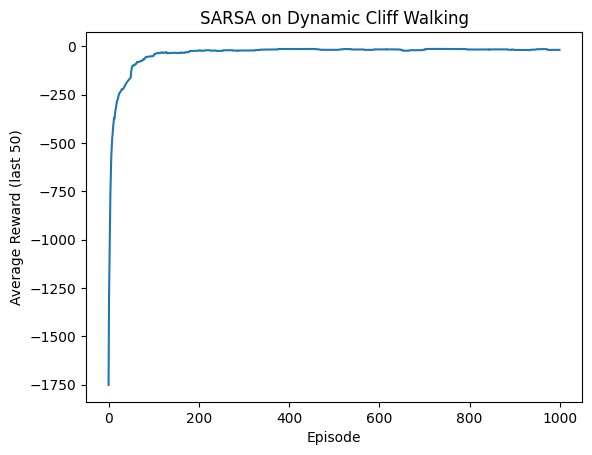

In [7]:
#Evaluate Adaptation

import matplotlib.pyplot as plt

def moving_average(x, N=50):
    return [sum(x[max(0, i-N):i]) / (i - max(0, i-N)) for i in range(1, len(x)+1)]

mdp = CliffWalkMDP()
policy, Q, total_rewards = sarsa(mdp, num_episodes=1000, alpha=0.1, epsilon=0.1)
ma = moving_average(total_rewards, N=50)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Average Reward (last 50)')
plt.title('SARSA on Dynamic Cliff Walking')
plt.show()



In [9]:
print("Policy at (1,1):", policy.get((1,1)))
print("Policy at (2,1):", policy.get((2,1)))
print("Policy at (4,11):", policy.get((4,11)))


Policy at (1,1): up
Policy at (2,1): down
Policy at (4,11): None


Short Report:

How does SARSA handle the dynamic cliﬀ compared to a static environment?

SARSA, as an on-policy learning algorithm, adapts to the dynamic (moving) cliff because it continually updates its Q-values based on new experience. When the environment shifts every 100 episodes and the cliff moves to a different position, SARSA’s exploration phase (via ϵ-greedy actions) allows the agent to encounter the new cliff and experience the heavy penalty. The Q-values for state-action pairs near the new cliff are rapidly updated to reflect the high cost, causing the policy to adjust and avoid the new hazardous region. In contrast, in a static environment, once the agent learns to avoid the fixed cliff, the policy stabilizes and little further change is needed. The dynamic case requires the agent to keep adapting, and performance typically drops immediately after each cliff shift, then recovers as the policy retunes to the new hazard zone.

What role does ϵ play in adapting to the change?

The parameter ϵ controls exploration. When the cliff shifts, a purely greedy (ϵ=0) agent might never discover the new hazard if it always exploits its old policy. With a positive ϵ (eg: 0.1), SARSA sometimes chooses random actions, allowing the agent to stumble into the newly positioned cliff, experience the penalty, and correct its policy. Thus, a nonzero ϵ is critical for the agent to continue exploring and quickly adapt to the shifting cliff. Too little exploration slows learning about the new cliff; too much can degrade overall policy performance, so a moderate setting balances adaptation and exploitation.